**Основное**
- Дедлайн - 21 июня 23:59
- Целевая метрика precision@5
- Бейзлайн решения - [MainRecommender](https://github.com/geangohn/recsys-tutorial/blob/master/src/recommenders.py)
- Сдаем ссылку на github с решением. На github должен быть файл recommendations.csv (user_id | [rec_1, rec_2, ...] с рекомендациями. rec_i - реальные id item-ов (из retail_train.csv)

**Hints:** 

Сначала просто попробуйте разные параметры MainRecommender:  
- N в топ-N товарах при формировании user-item матирцы (сейчас топ-5000)  
- Различные веса в user-item матрице (0/1, кол-во покупок, log(кол-во покупок + 1), сумма покупки, ...)  
- Разные взвешивания матрицы (TF-IDF, BM25 - у него есть параметры)  
- Разные смешивания рекомендаций (обратите внимание на бейзлайн - прошлые покупки юзера)  

Сделайте MVP - минимально рабочий продукт - (пусть даже top-popular), а потом его улучшайте

Если вы делаете двухуровневую модель - следите за валидацией 

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 25%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 

In [1]:
!pip install implicit

In [2]:
!pip install implicit swifter

     -------------------------------------- 830.9/830.9 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16307 sha256=2451eb75fb2845e3e79f26ee3d2331e1d65bd85e31a832c884caea3fbb28adc9
  Stored in directory: c:\users\reshe\appdata\local\pip\cache\wheels\a0\14\c9\e0021341138931942f10d0ec366ea7ad1fbe06726302f6b0b3
Successfully built swifter


In [1]:
import pandas as pd
import swifter

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [2]:
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [71]:
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

## Загрузка данных

In [15]:
data = pd.read_csv('./retail_train.csv')
item_features = pd.read_csv('./product.csv')
user_features = pd.read_csv('./hh_demographic.csv')

## Работа с столбцами

In [16]:
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

In [20]:
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy() 
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.390,364,-0.600,1631,1,0.000,0.000
1,2375,26984851472,1,1033142,1,0.820,364,0.000,1631,1,0.000,0.000


## Анализ пользователей

In [21]:
users_lvl_1 = data_train_lvl_1.user_id.unique()
users_lvl_2 = data_val_lvl_1.user_id.unique()
users_lvl_3 = data_val_lvl_2.user_id.unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

print('Количество пользователей в интервале до 6 нед:', new_users_lvl_2)
print('Количество новых пользователей в интервале 6 нед:', new_users_lvl_3)
print('Количество новых пользователей в интервале 3 нед:', len(add_to_lvl_2))

Количество пользователей в интервале до 6 нед: [1984]
Количество новых пользователей в интервале 6 нед: []
Количество новых пользователей в интервале 3 нед: 126


In [22]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.390,364,-0.600,1631,1,0.000,0.000
1,2375,26984851472,1,1033142,1,0.820,364,0.000,1631,1,0.000,0.000
2,2375,26984851472,1,1036325,1,0.990,364,-0.300,1631,1,0.000,0.000
3,2375,26984851472,1,1082185,1,1.210,364,0.000,1631,1,0.000,0.000
4,2375,26984851472,1,8160430,1,1.500,364,-0.390,1631,1,0.000,0.000


In [23]:
data.shape

(2396804, 12)

In [27]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [28]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               92353 non-null  int64 
 1   manufacturer          92353 non-null  int64 
 2   department            92353 non-null  object
 3   brand                 92353 non-null  object
 4   commodity_desc        92353 non-null  object
 5   sub_commodity_desc    92353 non-null  object
 6   curr_size_of_product  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [29]:
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13
4,45-54,B,50-74K,Homeowner,Single Female,1,None/Unknown,16


In [30]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age_desc             801 non-null    object
 1   marital_status_code  801 non-null    object
 2   income_desc          801 non-null    object
 3   homeowner_desc       801 non-null    object
 4   hh_comp_desc         801 non-null    object
 5   household_size_desc  801 non-null    object
 6   kid_category_desc    801 non-null    object
 7   user_id              801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


In [31]:
data['week_no'].nunique()

95

In [32]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print(f'# users: {users}')
print(f'# items: {items}')
print(f'# interactions: {interactions}')
     

# users: 2499
# items: 89051
# interactions: 2396804


In [33]:
popularity = data.groupby('item_id')['sales_value'].sum().reset_index()
popularity.describe()

,item_id,sales_value
count,89051.000,89051.000
mean,5115771.858,83.458
std,5178973.330,1628.715
min,25671.000,0.000
25%,966583.000,3.500
50%,1448516.000,10.780
75%,9553041.500,46.105
max,18024556.000,467993.620


In [34]:
popularity = data.groupby('item_id')['user_id'].nunique().reset_index()
popularity.describe()

,item_id,user_id
count,89051.000,89051.000
mean,5115771.858,14.760
std,5178973.330,45.904
min,25671.000,1.000
25%,966583.000,1.000
50%,1448516.000,2.000
75%,9553041.500,10.000
max,18024556.000,2039.000


In [52]:
data.nunique()

user_id                2499
basket_id            257001
day                     663
item_id               89051
quantity              11246
sales_value            5435
store_id                573
retail_disc            2364
trans_time             1440
week_no                  95
coupon_disc             393
coupon_match_disc        79
dtype: int64

In [53]:
item_features.nunique()

item_id                 92353
manufacturer             6476
department                 44
brand                       2
commodity_desc            308
sub_commodity_desc       2383
curr_size_of_product     4345
dtype: int64

In [54]:
user_features.nunique()

age_desc                 6
marital_status_code      3
income_desc             12
homeowner_desc           5
hh_comp_desc             6
household_size_desc      5
kid_category_desc        4
user_id                801
dtype: int64

In [55]:
item_features['department'].unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [56]:
for column in user_features.columns[:-1]:
    print(column, ':', user_features[column].unique(), '\n')

age_desc : ['65+' '45-54' '25-34' '35-44' '19-24' '55-64'] 

marital_status_code : ['A' 'U' 'B'] 

income_desc : ['35-49K' '50-74K' '25-34K' '75-99K' 'Under 15K' '100-124K' '15-24K'
 '125-149K' '150-174K' '250K+' '175-199K' '200-249K'] 

homeowner_desc : ['Homeowner' 'Unknown' 'Renter' 'Probable Renter' 'Probable Owner'] 

hh_comp_desc : ['2 Adults No Kids' '2 Adults Kids' 'Single Female' 'Unknown'
 'Single Male' '1 Adult Kids'] 

household_size_desc : ['2' '3' '4' '1' '5+'] 

kid_category_desc : ['None/Unknown' '1' '2' '3+'] 



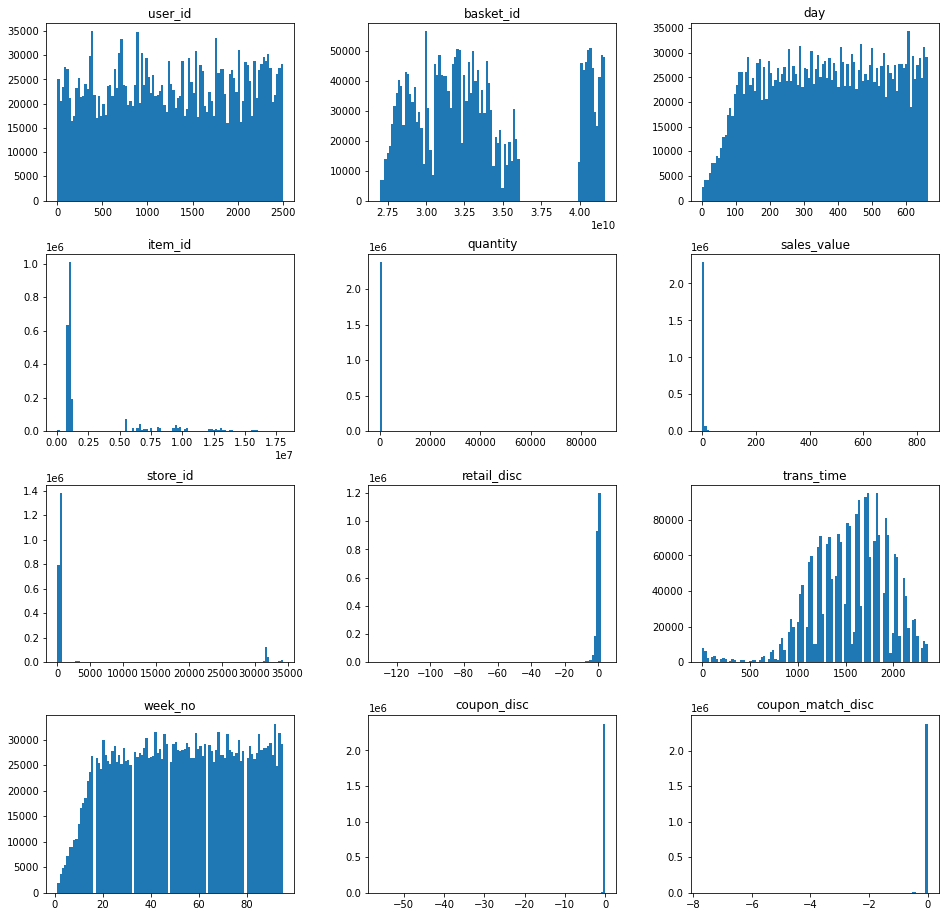

In [57]:
data.hist(figsize=(16,16), bins=100, grid=False);

In [59]:
from scipy.stats.stats import pearsonr

pearsonr(data['week_no'], data['day'])[0]

<ipython-input-59-c2549efc8888>:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


0.9999312126293736

In [62]:
from matplotlib import pyplot as plt

In [64]:
import seaborn as sns

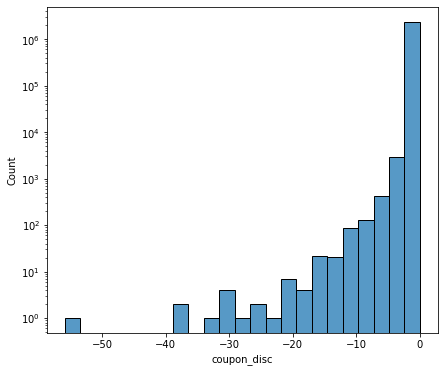

In [65]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['coupon_disc']);

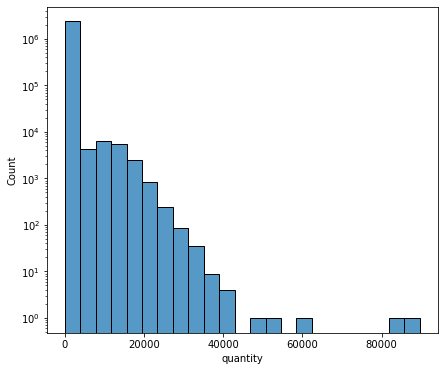

In [66]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['quantity']);

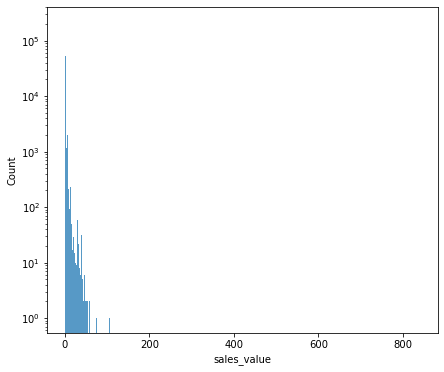

In [67]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['sales_value']);

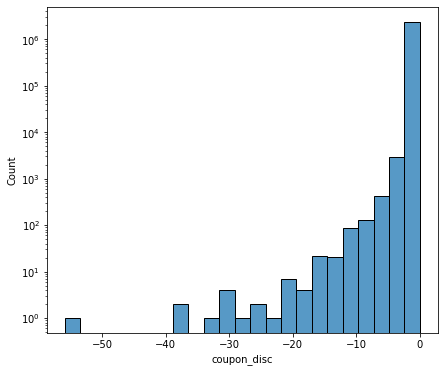

In [68]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['coupon_disc']);

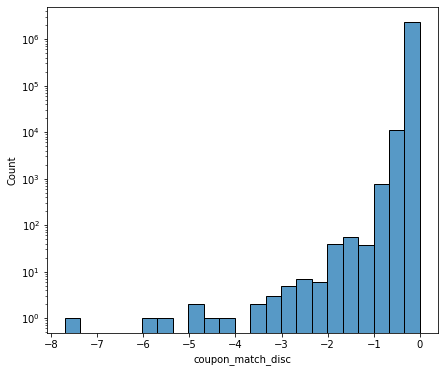

In [69]:
f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.histplot(data=data['coupon_match_disc']);

## Количество уникальных items и user до и после префильтрации data_train_lvl_1

In [72]:
n_items_before = data_train_lvl_1['item_id'].nunique()
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=5000)
n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


In [73]:
user_features.nunique()

age_desc                 6
marital_status_code      3
income_desc             12
homeowner_desc           5
hh_comp_desc             6
household_size_desc      5
kid_category_desc        4
user_id                801
dtype: int64

## Перекодируем признаки

In [74]:
user_features['age_desc'].replace(
    {'19-24': 22, '25-34': 30, '35-44': 40, '45-54': 50, '55-64': 60, '65+': 70},
    inplace=True)

user_features['marital_status_code'].replace(
    {'U': 0, 'A': 1, 'B': 2}, inplace=True)

user_features['income_desc'].replace(
    {'Under 15K': 10, '15-24K': 20, '25-34K':30, '35-49K': 40,
     '50-74K': 62, '75-99K': 87, '100-124K': 112, '125-149K': 137, 
     '150-174K': 162, '175-199K': 187, '200-249K': 225, '250K+':275}, inplace=True)

user_features['homeowner_desc'].replace(
    {'Unknown': 0, 'Probable Renter': 1, 'Renter': 2,
     'Probable Owner': 3, 'Homeowner': 4}, inplace=True)

user_features['hh_comp_desc'].replace(
    {'Unknown': 0, 'Single Male': 1, 'Single Female': 2,
     '1 Adult Kids': 3, '2 Adults No Kids': 4, '2 Adults Kids':5},inplace=True)

user_features['household_size_desc'].replace({'5+': 5}, inplace=True) 

user_features['kid_category_desc'].replace(
    {'None/Unknown': 0, '3+': 3}, inplace=True)

user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,70,1,40,4,4,2,0,1
1,50,1,62,4,4,2,0,7


In [75]:
names = ['manufacturer', 'department', 'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product']
for name in names:
    new_name = name + '_freq'
    a = item_features[name].value_counts()
    ind = a.index.tolist()
    for i in ind:
        item_features.loc[item_features[name] == i, new_name] = a[i]

item_features['brand'] = np.where(item_features['brand']=='Private', 0, 1)

commodities = item_features.commodity_desc.value_counts()
commodities_list = commodities.keys().tolist()
for i, name in enumerate(commodities_list):
    item_features.loc[item_features['commodity_desc'] == name, 'commodity_category'] = i

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,manufacturer_freq,department_freq,commodity_desc_freq,sub_commodity_desc_freq,curr_size_of_product_freq,commodity_category
0,25671,2,GROCERY,1,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1411.000,39021.000,29.000,29.000,12.000,270.000
1,26081,2,MISC. TRANS.,1,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1411.000,490.000,490.000,429.000,30607.000,56.000


## Новые признаки пользователей и товаров на основе матрицы транзакций

In [76]:
def get_user_item_features(data_train_lvl_1):
    # час 
    X = data_train_lvl_1.copy()
    X['hour'] = X['trans_time'] // 100
    user_item_features = X.groupby(['user_id', 'item_id'])['hour'].median().reset_index()
    user_item_features.columns = ['user_id', 'item_id', 'median_sales_hour']
    
    # день недели
    X['weekday'] = X['day'] % 7
    df = X.groupby(['user_id', 'item_id'])['weekday'].median().reset_index()
    df.columns = ['user_id', 'item_id', 'median_weekday']
    user_item_features = user_item_features.merge(df, on=['user_id', 'item_id'])
    
    # дни между покупками
    df = X.groupby('user_id')['day'].nunique().reset_index()
    df['mean_visits_interval'] = (X.groupby('user_id')['day'].max() - X.groupby('user_id')['day'].min()) / df['day']
    user_item_features = user_item_features.merge(df[['user_id', 'mean_visits_interval']], on=['user_id'])
    
    # средний чек
    df = X.groupby(['user_id', 'basket_id'])['sales_value'].sum().reset_index()
    df = df.groupby('user_id')['sales_value'].mean().reset_index()
    df.columns = ['user_id', 'mean_check']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # магазины
    df = X.groupby(['item_id'])['store_id'].nunique().reset_index()
    df.columns = ['item_id', 'n_stores']
    user_item_features = user_item_features.merge(df, on=['item_id'])
    
    # товары
    df = X.groupby(['user_id'])['item_id'].nunique().reset_index()
    df.columns = ['user_id', 'n_items']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # транзакции
    df = X.groupby(['user_id'])['item_id'].count().reset_index()
    df.columns = ['user_id', 'n_transactions']
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    # уникальность товаров
    df = X.groupby(['user_id', 'basket_id'])['item_id'].nunique().reset_index()
    df1 = df.groupby('user_id')['item_id'].mean().reset_index()
    df1.columns = ['user_id', 'mean_n_items_basket']
    user_item_features = user_item_features.merge(df1, on=['user_id'])

    df2 = df.groupby('user_id')['item_id'].max().reset_index()
    df2.columns = ['user_id', 'max_n_items_basket']
    user_item_features = user_item_features.merge(df2, on=['user_id'])

    df3 = df.groupby('user_id')['item_id'].std().reset_index()
    df3.columns = ['user_id', 'std_n_items_basket']
    user_item_features = user_item_features.merge(df3, on=['user_id'])

    
    recommender = MainRecommender(X)
    df = recommender.model.item_factors
    n_factors = recommender.model.factors
    ind = list(recommender.id_to_itemid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['item_id'] + ['factor_' + str(i + 1) for i in range(n_factors)]
    user_item_features = user_item_features.merge(df, on=['item_id'])
    
    
    df = recommender.model.user_factors
    ind = list(recommender.id_to_userid.values())
    df = pd.DataFrame(df, index=ind).reset_index()
    df.columns = ['user_id'] + ['user_factor_' + str(i + 1) for i in range(n_factors)]
    user_item_features = user_item_features.merge(df, on=['user_id'])
    
    return user_item_features

In [77]:
user_item_features = get_user_item_features(data_train_lvl_1)
user_item_features.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2495 [00:00<?, ?it/s]

ValueError: Shape of passed values is (2495, 20), indices imply (5001, 20)

## Формирование признаков для обучения модели второго уровня

In [78]:
def get_candidates(data_train_lvl_1, data_train_lvl_2, N, add_to_lvl_2):
    recommender = MainRecommender(data_train_lvl_1)

    users_lvl_1 = data_train_lvl_1['user_id'].unique()
    users_lvl_2 = data_train_lvl_2['user_id'].unique().tolist()
    if add_to_lvl_2:
        users_lvl_2 += add_to_lvl_2

    current_users = list(set(users_lvl_2) & set(users_lvl_1))    
    new_users = list(set(users_lvl_2) - set(users_lvl_1))

    df = pd.DataFrame(users_lvl_2, columns=['user_id'])
    cond_1 = df['user_id'].isin(current_users)
    df.loc[cond_1, 'candidates'] = df.loc[cond_1, 'user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N))

    if new_users:
        cond_2 = df['user_id'].isin(new_users)
        df.loc[cond_2, 'candidates'] = df.loc[cond_2, 'user_id'].apply(
            lambda x: recommender.overall_top_purchases[:N])
        
    return df



def get_targets_lvl_2(data_train_lvl_1, data_train_lvl_2, user_item_features, N, add_to_lvl_2=None):
    
    users_lvl_2 = get_candidates(data_train_lvl_1, data_train_lvl_2, N, add_to_lvl_2)
    
    df = pd.DataFrame({'user_id': users_lvl_2['user_id'].values.repeat(N),
                       'item_id': np.concatenate(users_lvl_2['candidates'].values)})

    targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
    targets_lvl_2['target'] = 1  # тут только покупки 

    targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')
    targets_lvl_2['target'].fillna(0, inplace= True)
    

    targets_lvl_2 = targets_lvl_2.merge(
        user_item_features, on=['user_id', 'item_id'], how='left')
    
    return targets_lvl_2

In [ ]:
N = 500
targets_lvl_2 = get_targets_lvl_2(data_train_lvl_1, data_train_lvl_2, user_item_features, N, add_to_lvl_2)

print(f'число пользователей: {targets_lvl_2.user_id.nunique()}')
print(f'среднее число покупок: {round(targets_lvl_2["target"].mean(), 4)}')

targets_lvl_2.head(2)

## Отбор признаков

In [80]:
SELECTED_FEATURES_NAMES = ['brand', 'manufacturer_freq', 'department_freq', 'commodity_desc_freq',
                           'sub_commodity_desc_freq', 'curr_size_of_product_freq',
                           'commodity_category', 'age_desc', 'marital_status_code', 'income_desc',
                           'homeowner_desc', 'hh_comp_desc'
                           
                             
                           'manufacturer',
                           
                           'median_sales_hour', 'median_weekday', 
                           'mean_check', 
                           'n_stores', 'n_items', 'n_transactions', 
                           'mean_n_items_basket', 'max_n_items_basket', 'std_n_items_basket',
                           'mean_n_item_categories_basket', 'max_n_item_categories_basket', 
                           'std_n_item_categories_basket',
                           'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5',
                           'factor_6', 'factor_7', 'factor_8', 'factor_9', 'factor_10',
                           'factor_11', 'factor_12', 'factor_13', 'factor_14', 'factor_15',
                           'factor_16', 'factor_17', 'factor_18', 'factor_19', 'factor_20',
                           
                           'user_factor_1', 'user_factor_2', 'user_factor_3', 'user_factor_4',
                           'user_factor_5', 'user_factor_6', 'user_factor_7', 'user_factor_8',
                           'user_factor_9', 'user_factor_10', 'user_factor_11', 'user_factor_12',
                           'user_factor_13', 'user_factor_14', 'user_factor_15', 'user_factor_16',
                           'user_factor_17', 'user_factor_18', 'user_factor_19', 'user_factor_20',
                          ]
categorical = ['marital_status_code','homeowner_desc', 'hh_comp_desc', 'manufacturer','commodity_category']

## Модели второго уровня

In [81]:
SELECTED_FEATURES_NAMES_cb = [i for i in SELECTED_FEATURES_NAMES if not i in categorical]

In [82]:
def run_model_cb(targets_lvl_2):    
    X_train, X_valid, y_train, y_valid = train_test_split(targets_lvl_2[SELECTED_FEATURES_NAMES_cb].fillna(0),
                                                          targets_lvl_2[['target']],
                                                          test_size=0.2, random_state=16,
                                                          stratify=targets_lvl_2[['target']])

    dtrain = Pool(data=X_train, label=y_train) 
    dvalid = Pool(data=X_valid, label=y_valid) 

    params_cb = {"n_estimators":5000,
                 "loss_function": "Logloss",
                 "eval_metric": "AUC",
                 "task_type": "CPU",
                 "max_bin": 30,
                 "early_stopping_rounds": 30,
                 "verbose": 1000,
                 "l2_leaf_reg": 80,
                 "thread_count": 6,
                 "random_seed": 51} 

    model_cb = CatBoostClassifier(**params_cb)
    model_cb.fit(dtrain, eval_set=[dvalid])

    
    return model_cb

In [ ]:
model_cb = run_model_cb(targets_lvl_2)

In [ ]:
print(model_cb.get_all_params())

In [85]:
def run_model_lgb(targets_lvl_2):
    X_train, X_valid, y_train, y_valid = train_test_split(targets_lvl_2[SELECTED_FEATURES_NAMES].fillna(0),
                                                          targets_lvl_2[['target']],
                                                          test_size=0.2, random_state=16,
                                                          stratify=targets_lvl_2[['target']])

    dtrain = lgb.Dataset(X_train, y_train, categorical_feature=categorical)
    dvalid = lgb.Dataset(X_valid, y_valid, categorical_feature=categorical)

    params_lgb = {
                  "objective": "binary", 
                  "metric": "auc",
                  "num_boost_round": 10000, 
                  "n_jobs": 8,
                  "force_row_wise": True, 
                  "seed": 24} 

    model_lgb = lgb.train(params=params_lgb,
                          train_set=dtrain,  
                          valid_sets=[dtrain, dvalid],
                          categorical_feature=categorical,
                          verbose_eval=1000,
                          early_stopping_rounds=30)
    
    return model_lgb

## Генерация прогнозов

In [ ]:
predictions_lgb_train = model_lgb.predict(targets_lvl_2[SELECTED_FEATURES_NAMES].fillna(0))
predictions_cb_train = model_cb.predict_proba(targets_lvl_2[SELECTED_FEATURES_NAMES_cb].fillna(0))[:, 1]

## Объединение прогнозов

In [ ]:
preds_train = pd.DataFrame(zip(predictions_lgb_train, 
                               predictions_cb_train),
                           columns=['lgb', 'cb']).mean(axis=1).values
roc_auc_score(targets_lvl_2['target'], preds_train)

## Обработка прогнозов

In [90]:
def get_predictions(targets_lvl_2, raw_predictions, prefix='lgb'): 
    df = targets_lvl_2[['user_id', 'item_id']]
    df['predictions'] = raw_predictions

    df = df.groupby(['user_id', 'item_id'])['predictions'].median().reset_index()
    df = df.sort_values(['predictions'], ascending=False).groupby(['user_id']).head(5)

    df = df.groupby('user_id')['item_id'].unique().reset_index()
    df.columns = ['user_id', prefix + '_recommendations']
    
    return df


def get_results(data_val_lvl_2, targets_lvl_2, preds_lgb, preds_cb, combined_preds):
    result = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
    result.columns=['user_id', 'actual']
    
    prefixes = ['lgb', 'cb', 'cb_lgb']
    predictions = [preds_lgb, preds_cb, combined_preds]
    
    for i, preds in enumerate(predictions):
        df = get_predictions(targets_lvl_2, preds, prefixes[i])
        result = result.merge(df, on='user_id', how='left')

    return result

## Построение прогнозов

In [95]:
validation_weeks = 6
data_train = data[data['week_no'] < data['week_no'].max() - validation_weeks]
data_valid = data[data['week_no'] >= data['week_no'].max() - validation_weeks]

In [96]:
test = pd.read_csv('./predictions_basic.csv')

In [97]:
users_lvl_1 = data_train.user_id.unique()
users_lvl_2 = data_valid.user_id.unique()
users_lvl_3 = test.user_id.unique()

new_users_lvl_2 = list(set(users_lvl_2) - set(users_lvl_1))
new_users_lvl_3 = list(set(users_lvl_3) - (set(users_lvl_1) | set(users_lvl_2)))

add_to_lvl_2 = list(set(users_lvl_3) - (set(users_lvl_2)))

new_users_lvl_2, new_users_lvl_3, len(add_to_lvl_2)

([], [], 0)

In [98]:
import os
os.chdir('./src')
%run utils.py

In [99]:
n_items_before = data['item_id'].nunique()
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=5000)
n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 89051 to 5001


In [100]:
user_item_features = get_user_item_features(data_train)
user_item_features.head(2)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2496 [00:00<?, ?it/s]

ValueError: Shape of passed values is (2496, 20), indices imply (5001, 20)

In [105]:
SELECTED_FEATURES_NAMES = ['median_sales_hour', 'median_weekday', #'mean_visits_interval',
                           'mean_check', 
                           'n_stores', 'n_items', 'n_transactions', 
                           'mean_n_items_basket', 'max_n_items_basket', 
                           
                          
                           'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5',
                           'factor_6', 'factor_7', 'factor_8', 'factor_9', 'factor_10',
                           'factor_11', 'factor_12', 'factor_13', 'factor_14', 'factor_15',
                           'factor_16', 'factor_17', 'factor_18', 'factor_19', 'factor_20',
                           
                           'user_factor_1', 'user_factor_2', 'user_factor_3', 'user_factor_4',
                           'user_factor_5', 'user_factor_6', 'user_factor_7', 'user_factor_8',
                           'user_factor_9', 'user_factor_10', 'user_factor_11', 'user_factor_12',
                           'user_factor_13', 'user_factor_14', 'user_factor_15', 'user_factor_16',
                           'user_factor_17', 'user_factor_18', 'user_factor_19', 'user_factor_20',
                          ]
categorical = []

In [111]:
test.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases
0,1,[ 821867 834484 856942 865456 889248 ...,"[5586238, 1015228, 866118, 2416733, 2603573]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 1127831, 1098066, 826249, 878996]","[981760, 1127831, 1098066, 878996, 826249]","[981760, 1127831, 1098066, 826249, 878996]","[999999, 1082185, 1029743, 995785, 1004906]"
1,3,[ 835476 851057 872021 878302 879948 ...,"[161354, 63027, 1027802, 12263694, 307395]","[6534178, 6533889, 1029743, 6534166, 1082185]","[981760, 995242, 1029743, 840361, 961554]","[981760, 1004906, 961554, 1096036, 1080414]","[981760, 1004906, 859075, 1096036, 961554]","[999999, 1082185, 1098066, 6534178, 1127831]"


In [113]:
def get_results_1(data_val_lvl_2, targets_lvl_2, preds_lgb, preds_cb, combined_preds):
    result = data_val_lvl_2.groupby('user_id')['actual'].unique().reset_index()
    result.columns=['user_id', 'actual']
    
    prefixes = ['lgb', 'cb', 'cb_lgb']
    predictions = [preds_lgb, preds_cb, combined_preds]
    
    for i, preds in enumerate(predictions):
        df = get_predictions(targets_lvl_2, preds, prefixes[i])
        result = result.merge(df, on='user_id', how='left')

    return result

Metrics.py

In [119]:
def money_precision_at_k(y_pred: pd.Series, y_true: pd.Series, item_price, k=5):
    y_pred = y_pred.swifter.progress_bar(False).apply(pd.Series)
    user_filter = ~(y_true.swifter.progress_bar(False).apply(len) < k)

    y_pred = y_pred.loc[user_filter]
    y_true = y_true.loc[user_filter]

    prices_recommended = y_pred.swifter.progress_bar(False).applymap(lambda item: item_price.price.get(item))
    flags = y_pred.loc[:, :k - 1].swifter.progress_bar(False) \
        .apply(lambda row: np.isin(np.array(row), y_true.get(row.name)), axis=1) \
        .swifter.progress_bar(False).apply(pd.Series)

    metric = (
        (flags * prices_recommended.loc[:, :k - 1]).sum(axis=1) / prices_recommended.loc[:, :k - 1].sum(axis=1)
    ).mean()
    return metric

### Utils.py

In [121]:
import pandas as pd
import swifter
import numpy as np


def optimizing_df(df, silent=False, width_line=100):
    assert isinstance(df, pd.DataFrame), 'This is not a dataframe'

    if not silent:
        start_memory_usage = df.memory_usage(deep=True).sum() / 1024**2
        print('Start of dataframe memory optimization'.center(width_line, '*'))
        print(f'Memory usage by dataframe: {start_memory_usage:.02f} MB')

    df_dtype = pd.DataFrame(df.dtypes, columns=['dtype'], index=df.columns)

    df_dtype['min'] = df.select_dtypes(['int', 'float']).min()
    df_dtype['max'] = df.select_dtypes(['int', 'float']).max()
    df_dtype['is_int'] = ~(df.select_dtypes(['int', 'float']).fillna(0).astype(int) - df.select_dtypes(['int', 'float']).fillna(0)).sum().astype('bool_')

    df_dtype.loc[(df_dtype['is_int'] == True), 'dtype'] = 'int64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int32').min) & (df_dtype['max'] <= np.iinfo('int32').max), 'dtype'] = 'int32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int16').min) & (df_dtype['max'] <= np.iinfo('int16').max), 'dtype'] = 'int16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('int8').min) & (df_dtype['max'] <= np.iinfo('int8').max), 'dtype'] = 'int8'

    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint64').min) ,'dtype'] = 'uint64'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint32').min) & (df_dtype['max'] <= np.iinfo('uint32').max), 'dtype'] = 'uint32'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint16').min) & (df_dtype['max'] <= np.iinfo('uint16').max), 'dtype'] = 'uint16'
    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] >= np.iinfo('uint8').min) & (df_dtype['max'] <= np.iinfo('uint8').max), 'dtype'] = 'uint8'

    df_dtype.loc[(df_dtype['is_int'] == True) & (df_dtype['min'] == 0) & (df_dtype['max'] == 1),'dtype'] = 'bool_'

    df_dtype.loc[(df_dtype['is_int'] == False), 'dtype'] = 'float64'
    df_dtype.loc[(df_dtype['is_int'] == False) & (df_dtype['min'] >= np.finfo('float32').min) & (df_dtype['max'] <= np.finfo('float32').max), 'dtype'] = 'float32'

    for col in df.select_dtypes('object').columns:
        num_unique_values = df[col].nunique()
        num_total_values = df[col].count()
        if num_unique_values / num_total_values < 0.5:
            df_dtype.loc[col, 'dtype'] = 'category'

    dtypes = df_dtype['dtype'].to_dict()

    df = df.astype(dtypes)

    if not silent:
        memory_usage = df.memory_usage(deep=True).sum() / 1024**2
        print('MEMORY USAGE AFTER COMPLETION:'.center(width_line, '_'))
        print(f'Memory usage of properties dataframe is : {memory_usage:.02f} MB')
        print(f'This is {100 * memory_usage / start_memory_usage:.02f} % of the initial size')
    return df


def postfilter_items(recommendations, item_info=None, user_history=None, n_rec=5, n_new=2, n_exp=1, price_lte=7):
    recommendations = recommendations.swifter.progress_bar(False).apply(pd.Series)

    mask_unique = recommendations.swifter.progress_bar(False) \
        .apply(lambda row: ~pd.Series(row).duplicated(), axis=1)

    mask_sub_commodity = recommendations.fillna(item_info.index.max() + 1) \
        .swifter.progress_bar(False) \
        .applymap(lambda item: item_info.SUB_COMMODITY_DESC.get(item)) \
        .swifter.progress_bar(False) \
        .apply(lambda row: ~pd.Series(row).duplicated(), axis=1)

    mask = mask_unique & mask_sub_commodity

    recommendations = recommendations.where(mask) \
        .swifter.progress_bar(False) \
        .apply(lambda row: np.array(row), axis=1) \
        .swifter.progress_bar(False) \
        .apply(lambda item: item[~np.isnan(item)]) \
        .swifter.progress_bar(False) \
        .apply(pd.Series)
    if user_history is not None:
        rec_new = recommendations.fillna(user_history.index.max() + 1) \
            .swifter.progress_bar(False) \
            .apply(lambda row: ~np.isin(np.array(row), user_history.get(row.name)), axis=1) \
            .swifter.progress_bar(False).apply(pd.Series)
        rec_new_filter = rec_new.loc[rec_new.loc[:, :n_rec - 1].sum(axis=1) < n_new]
        mask_new = rec_new_filter.swifter.progress_bar(False) \
            .apply(lambda row: postfilter_for_item(row, n=n_new, n_rec=n_rec), axis=1).swifter \
            .progress_bar(False).apply(pd.Series)
        recommendations.loc[mask_new.index] = recommendations.loc[mask_new.index].where(mask_new.apply(pd.Series))
        recommendations = recommendations.swifter.progress_bar(False) \
            .apply(lambda row: np.array(row), axis=1) \
            .swifter.progress_bar(False).apply(lambda item: item[~np.isnan(item)]) \
            .swifter.progress_bar(False).apply(pd.Series)
    if item_info is not None:
        rec_exp = recommendations.fillna(item_info.index.max() + 1) \
            .swifter.progress_bar(False).applymap(lambda item: item_info.price.get(item))
        rec_exp_filter = rec_exp.loc[(rec_exp.loc[:, :n_rec - 1] >= price_lte).sum(axis=1) < n_exp]
        mask_exp = rec_exp_filter.swifter.progress_bar(False) \
            .apply(lambda row: postfilter_for_item(row, n=n_exp, n_rec=n_rec), axis=1) \
            .swifter.progress_bar(False).apply(pd.Series)
        recommendations.loc[mask_exp.index] = recommendations.loc[mask_exp.index] \
            .where(mask_exp.apply(pd.Series))
        recommendations = recommendations.swifter.progress_bar(False) \
            .apply(lambda row: np.array(row, dtype='uint'), axis=1) \
            .swifter.progress_bar(False).apply(lambda item: item[~np.isnan(item)]) \
            .swifter.progress_bar(False).apply(pd.Series)

    recommendations = recommendations.loc[:, :n_rec - 1].swifter.progress_bar(False) \
        .apply(lambda row: np.array(row), axis=1)
    return recommendations


def postfilter_for_item(items_mask, n=2, n_rec=5):
    mask = np.ones(len(items_mask), dtype=bool)
    n = n - items_mask[:n_rec].sum()
    n_low = n
    for index, item in enumerate(np.flip(items_mask[:n_rec])):
        if not item:
            mask[n_rec - index - 1] = False
            n_low -= 1
        if not n_low:
            break
    n_high = n
    for index, item in enumerate(items_mask[n_rec:]):
        if not item:
            mask[n_rec + index] = False
        else:
            n_high -= 1
        if not n_high:
            break
    return mask

### pipeline.py

In [122]:
import pandas as pd
import numpy as np
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight
from scipy.sparse import csr_matrix
from sklearn.base import BaseEstimator, TransformerMixin


class ColumnSelector(TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame), 'This is not a dataframe'
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError(f'DataFrame does not contain the following columns: {cols_error}')


class PrefilterItems(TransformerMixin, BaseEstimator):
    def __init__(
            self, take_n_popular=5000, item_features=None,
            filter_item_id=-99, n_last_week=52, price_low=2, price_high=50
    ):

        self.take_n_popular = take_n_popular
        self.item_features = item_features
        self.filter_item_id = filter_item_id
        self.n_last_week = n_last_week
        self.price_low = price_low
        self.price_high = price_high

    def _reset(self):
        if hasattr(self, 'is_fit_'):
            del self.is_fit_

    def fit(self, X, items=None):
        self._reset
        return self

    def transform(self, X, items=None):
        if not hasattr(self, 'is_fit_'):
            assert isinstance(X, pd.DataFrame), 'This is not a dataframe'
            # Уберем самые популярные товары (их и так купят)
            popularity = X.groupby('item_id')['user_id'].nunique().reset_index() / X['user_id'].nunique()
            popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

            top_popular = popularity[popularity['share_unique_users'] > 0.2].item_id.tolist()
            X = X[~X['item_id'].isin(top_popular)]
            # Уберем самые НЕ популярные товары (их и так НЕ купят)
            top_notpopular = popularity[popularity['share_unique_users'] < 0.02].item_id.tolist()
            X = X[~X['item_id'].isin(top_notpopular)]
            # Уберем товары, которые не продавались за последние n недель
            last_time = X.week_no.max() - self.n_last_week
            X = X.loc[X.item_id.isin(X.loc[X.week_no > last_time, 'item_id'])]
            # Уберем не интересные для рекоммендаций категории (department)
            if self.item_features is not None:
                department_size = self.item_features.groupby('department')['product_id'] \
                    .nunique().sort_values(ascending=False).rename('n_items')
                rare_departments = department_size[department_size > 150].index.tolist()
                items_in_rare_departments = self.item_features.loc[self.item_features['department']
                                                                   .isin(rare_departments)]['product_id'].unique().tolist()
                X = X.loc[X.item_id.isin(items_in_rare_departments)]
            # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
            X = X[X['price'] > self.price_low]
            # Уберем слишком дорогие товары
            X = X[X['price'] < self.price_high]
            # Возьмем топ по популярности
            popularity = X.groupby('item_id')['quantity'].sum().reset_index()
            popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

            top = popularity.sort_values('n_sold', ascending=False)[: self.take_n_popular].item_id.tolist()
            # Заведем фиктивный item_id (если юзер покупал товары из топ-n, то он "купил" такой товар)
            X.loc[~X['item_id'].isin(top), 'item_id'] = self.filter_item_id
            self.is_fit_ = True

        return X


class RandomEstimator(TransformerMixin, BaseEstimator):
    def __init__(
        self, n_rec=5, n_rec_pre=100, n_new=2, n_exp=1, price_lte=7,
        filter_item_id=-99, filter=True, filter_post=True,
        postfilter_func=None, random_state=42
    ):

        self.n_rec = n_rec
        self.n_rec_pre = n_rec_pre
        self.n_new = n_new
        self.n_exp = n_exp
        self.price_lte = price_lte
        self.filter_item_id = filter_item_id
        self.filter = filter
        self.filter_post = filter_post
        self.postfilter_func = postfilter_func
        self.random_state = random_state

    def _reset(self):
        if hasattr(self, 'items'):
            del self.items
        if hasattr(self, 'item_info'):
            del self.item_info
        if hasattr(self, 'user_history'):
            del self.user_history

    def fit(self, X, items=None):
        self._reset()
        self.items = X.item_id.unique()
        self.item_info = X.groupby('item_id').agg({'price': 'max', 'sub_commodity_desc': 'first'})
        self.user_history = pd.DataFrame(X.groupby('user_id').item_id.unique().rename('history'))

        if items is not None:
            self.items = items
        else:
            self.items = X.item_id.unique()
        if self.filter:
            self.items = self.items[np.where(self.items != self.filter_item_id)]
        return self

    def transform(self, X):
        X = X['user_id'].drop_duplicates()
        return X

    def predict(self, X):
        X = self.transform(X)

        if self.filter_post:
            n_rec = self.n_rec_pre
        else:
            n_rec = self.n_rec

        rec = X.swifter.progress_bar(False).apply(lambda x: self._random_recommendation(n_rec))
        rec.index = X.values

        if self.postfilter_func is not None and self.filter_post:
            rec = self.postfilter_func(
                rec,
                item_info=self.item_info,
                user_history=self.user_history,
                n_rec=self.n_rec,
                n_new=self.n_new,
                n_exp=self.n_exp,
                price_lte=self.price_lte,
            )

        assert (rec.swifter.progress_bar(False).apply(len) == self.n_rec).all(), f'The number of recommendations is not equal {self.n_rec}.'

        return rec

    def _random_recommendation(self, n_rec):
        np.random.seed(self.random_state)
        recs = np.random.choice(self.items, size=n_rec, replace=False, )
        return recs


class AlsEstimator(TransformerMixin, BaseEstimator):
    def __init__(
            self, recommendations='als', n_rec=5, n_rec_pre=100, n_new=2,
            n_exp=1, price_lte=7, filter_item_id=-99, filter=True, filter_post=True,
            postfilter_func=None, factors=50, regularization=0.01,
            iterations=10, matrix_values='quantity', matrix_aggfunc='count',
            weighting=True, use_native=True, use_gpu=False
    ):

        self.n_rec = n_rec
        self.n_rec_pre = n_rec_pre
        self.n_new = n_new
        self.n_exp = n_exp
        self.price_lte = price_lte
        self.filter_item_id = filter_item_id
        self.filter = filter
        self.filter_post = filter_post
        self.postfilter_func = postfilter_func

        self.factors = factors
        self.regularization = regularization
        self.iterations = iterations
        self.matrix_values = matrix_values
        self.matrix_aggfunc = matrix_aggfunc
        self.recommendations = recommendations
        self.weighting = True

        self.use_native = use_native
        self.use_gpu = use_gpu

    def _reset(self):
        if hasattr(self, 'item_info'):
            del self.item_info
        if hasattr(self, 'user_history'):
            del self.user_history
        if hasattr(self, 'top_purchases'):
            del self.top_purchases
        if hasattr(self, 'overall_top_purchases'):
            del self.overall_top_purchases
        if hasattr(self, 'user_item_matrix'):
            del self.user_item_matrix
        if hasattr(self, 'id_to_itemid'):
            del self.id_to_itemid
        if hasattr(self, 'id_to_userid'):
            del self.id_to_userid
        if hasattr(self, 'itemid_to_id'):
            del self.itemid_to_id
        if hasattr(self, 'userid_to_id'):
            del self.userid_to_id
        if hasattr(self, '_fit'):
            del self._fit

    @staticmethod
    def _prepare_matrix(data: pd.DataFrame, values: str, aggfunc: str):
        """Готовит user-item матрицу"""
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values=values,
                                          aggfunc=aggfunc,
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        """Подготавливает вспомогательные словари"""

        userids = user_item_matrix.index.values
        itemids = user_item_matrix.columns.values

        matrix_userids = np.arange(len(userids))
        matrix_itemids = np.arange(len(itemids))

        id_to_itemid = dict(zip(matrix_itemids, itemids))
        id_to_userid = dict(zip(matrix_userids, userids))

        itemid_to_id = dict(zip(itemids, matrix_itemids))
        userid_to_id = dict(zip(userids, matrix_userids))

        return id_to_itemid, id_to_userid, itemid_to_id, userid_to_id

    def fit(self, X, y=None):
        self._reset()
        self.item_info = X.groupby('item_id').agg({'price': 'max', 'sub_commodity_desc': 'first'})
        self.user_history = pd.DataFrame(X.groupby('user_id').item_id.unique().rename('history'))

        self.top_purchases = X.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.top_purchases = self.top_purchases[self.top_purchases['item_id'] != self.filter_item_id]

        # Топ покупок по всему датасету
        self.overall_top_purchases = X.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purchases.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purchases = self.overall_top_purchases[self.overall_top_purchases['item_id'] != self.filter_item_id]
        self.overall_top_purchases = self.overall_top_purchases.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(X, self.matrix_values, self.matrix_aggfunc)

        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if self.weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = AlternatingLeastSquares(
            factors=self.factors,
            regularization=self.regularization,
            iterations=self.iterations,
            dtype=np.float32,
            use_native=self.use_native,
            use_gpu=self.use_gpu,
        )

        self.model.fit(csr_matrix(self.user_item_matrix).T.tocsr())

        self.model_own_recommender = ItemItemRecommender(K=1)
        self.model_own_recommender.fit(csr_matrix(self.user_item_matrix).T.tocsr())

        self._fit = True

    def transform(self, X):
        if self._fit:
            X = X['user_id'].drop_duplicates()
            X.index = X.values
        return X

    def _update_dict(self, user_id):
        """Если появился новыю user / item, то нужно обновить словари"""

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        """Находит товар, похожий на item_id"""
        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # Товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # И берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recommendations):
        """Если кол-во рекоммендаций < N, то дополняем их топ-популярными"""

        if self.filter_post:
            n_rec = self.n_rec_pre
        else:
            n_rec = self.n_rec

        if len(recommendations) < n_rec:
            recommendations.extend(self.overall_top_purchases[:n_rec])
            recommendations = recommendations[:n_rec]

        return recommendations

    def _get_recommendations(self, user, model):
        """Рекомендации через стардартные библиотеки implicit"""
        if self.filter_post:
            n_rec = self.n_rec_pre
        else:
            n_rec = self.n_rec

        self._update_dict(user_id=user)
        try:
            res = [self.id_to_itemid[rec[0]] for rec in model.recommend(
                userid=self.userid_to_id[user],
                user_items=csr_matrix(self.user_item_matrix).tocsr(),
                N=n_rec,
                filter_already_liked_items=False,
                filter_items=[self.itemid_to_id[self.filter_item_id]],
                recalculate_user=True
            )]
        except:
            res = list()
        finally:
            res = self._extend_with_top_popular(res)

            assert len(res) == n_rec, 'Количество рекомендаций != {}'.format(n_rec)
            return res

    def get_als_recommendations(self, user):
        """Рекомендации через стардартные библиотеки implicit"""
        if self.filter_post:
            n_rec = self.n_rec_pre
        else:
            n_rec = self.n_rec

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model)

    def get_own_recommendations(self, user):
        """Рекомендуем товары среди тех, которые юзер уже купил"""

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model_own_recommender)

    def get_similar_items_recommendations(self, user):
        """Рекомендуем товары, похожие на топ-N купленных юзером товаров"""
        if self.filter_post:
            n_rec = self.n_rec_pre
        else:
            n_rec = self.n_rec

        top_users_purchases = self.top_purchases[self.top_purchases['user_id'] == user].head(n_rec)

        res = top_users_purchases['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res)

        assert len(res) == n_rec, 'Количество рекомендаций != {}'.format(n_rec)
        return res

    def predict(self, X):
        X = self.transform(X)
        recommender = getattr(self, f'get_{self.recommendations}_recommendations')

        rec = X.swifter.progress_bar(False).apply(lambda item: recommender(user=item))
        if self.postfilter_func is not None and self.filter_post:
            rec = self.postfilter_func(
                rec,
                item_info=self.item_info,
                user_history=self.user_history,
                n_rec=self.n_rec,
                n_new=self.n_new,
                n_exp=self.n_exp,
                price_lte=self.price_lte,
            )

        assert (rec.swifter.progress_bar(False).apply(len) == self.n_rec).all(), f'The number of recommendations is not equal {self.n_rec}.'

        return rec

### Price items

In [123]:
item_price = data.loc[data.quantity != 0, ['item_id', 'sales_value', 'quantity']] 

In [124]:
item_price['price'] = item_price.sales_value / item_price.quantity

In [125]:
item_price = item_price.groupby('item_id').agg({'price': 'max'})

In [128]:
data = optimizing_df(data)
data_valid = optimizing_df(data_valid)

*******************************Start of dataframe memory optimization*******************************
Memory usage by dataframe: 219.43 MB
___________________________________MEMORY USAGE AFTER COMPLETION:___________________________________
Memory usage of properties dataframe is : 182.86 MB
This is 83.33 % of the initial size
*******************************Start of dataframe memory optimization*******************************
Memory usage by dataframe: 20.16 MB
___________________________________MEMORY USAGE AFTER COMPLETION:___________________________________
Memory usage of properties dataframe is : 17.06 MB
This is 84.62 % of the initial size


### Train-test split

In [129]:
test_size_weeks = 3

X_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
X_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [130]:
X_train.shape[0], X_test.shape[0]

(2278490, 118314)

### Modelling

In [131]:
baseline_columns = ['user_id', 'item_id', 'quantity','week_no', 'price', 'SUB_COMMODITY_DESC']

In [132]:
pipeline_random = make_pipeline(
    ColumnSelector(baseline_columns),
    PrefilterItems(item_features=item_features),
    RandomEstimator(n_rec=5, postfilter_func=postfilter_items),
)

In [133]:
als_columns = ['user_id', 'item_id', 'quantity','week_no', 'price', 'sales_value', 'SUB_COMMODITY_DESC']

In [134]:
ilter_item_id=999999

pipeline_als = make_pipeline(
    ColumnSelector(als_columns),
    PrefilterItems(item_features=item_features, filter_item_id=ilter_item_id, n_last_week=26, take_n_popular=5000),
    AlsEstimator(
        matrix_values='quantity', matrix_aggfunc='count', recommendations='own',
        n_rec=5, postfilter_func=postfilter_items, filter_item_id=ilter_item_id, use_gpu=True
    )
)

### Grid search

In [135]:
def money_precision_scoring(estimator, X_test, item_price=item_price, k=5):
    y_true = X_test.groupby('user_id')['item_id'].unique() \
        .reset_index() \
        .rename(columns={'item_id': 'actual'}) \
        .set_index('user_id').actual
    y_pred = estimator.predict(X_test)
    return money_precision_at_k(y_pred=y_pred, y_true=y_true, item_price=item_price, k=k)